## OVERALL

### Predictor Selection Flow

1. Start with conceptual relevance
   - Does the variable plausibly relate to QoL calls during heat?
   - Categories: Heat/Weather, Built/Environment, Socioeconomic, Access/Urban form.

2. Data quality check
   - Missing rate > 30% → drop or impute carefully.
   - Extreme outliers? Consider winsorizing or transforming.

3. Univariate check
   - Strongly skewed? → log/√ transform if interpretable.
   - Almost no variance? → drop (no information).

4. Pairwise correlation
   - |r| > 0.8 with another variable? 
     - Keep:
       - More interpretable
       - Less noisy / more stable over time.

5. Multicollinearity (VIF)
   - VIF > 10 → strong multicollinearity.
   - Try:
     - Dropping redundant variables;
     - Combining into an index (e.g., “socioeconomic disadvantage”).

6. Model contribution
   - Add variable blockwise: Base → + Env → + ACS → + Urban.
   - Improve AIC/BIC or cross-validated R²

7. SHAP inspection (for XGBoost)
   - High |mean SHAP| and clear pattern → strong predictor.
   - Low SHAP impact and noisy pattern → candidate for dropping.


In [95]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from pathlib import Path

from libpysal.weights import KNN, Queen
from esda.moran import Moran, Moran_Local
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

In [96]:
# Paths

acs_path   = "data/acs/acs_socioeconomic_tract_2022.csv"
calls_path = "data/nyc_311/panel/nyc_311_tract_day_2025.csv"
env_path   = "data/raster/shapes/nyc_tracts_env_2025.shp"
heat_path  = "data/heat/JFK_2025_JJA_extreme_heat_90.csv"

acs   = pd.read_csv(acs_path)
calls = pd.read_csv(calls_path)
env   = gpd.read_file(env_path)
heat  = pd.read_csv(heat_path)

print("ACS:", acs.shape)
print("Calls:", calls.shape)
print("Env:", env.shape)
print("Heat:", heat.shape)

ACS: (2229, 10)
Calls: (162344, 5)
Env: (2325, 5)
Heat: (88, 3)


In [97]:
# Load data.
heat_path = Path("data/heat/JFK_2025_JJA_extreme_heat_90.csv")
acs_path = Path("data/acs/acs_socioeconomic_tract_2022.csv")
points_path = Path("data/nyc_311/panel/nyc_311_points_2025.geojson")
tracts311_path = Path("data/nyc_311/panel/nyc_311_tract_day_2025.csv")
env_path = Path("data/raster/shapes/nyc_tracts_env_2025.shp")

heat = pd.read_csv(heat_path)
acs = pd.read_csv(acs_path)
points = gpd.read_file(points_path)
tracts = pd.read_csv(tracts311_path)
env = gpd.read_file(env_path)

heat.columns = heat.columns.str.upper()
acs.columns = acs.columns.str.upper()
points.columns = points.columns.str.upper()
tracts.columns = tracts.columns.str.upper()
env.columns = env.columns.str.upper()

points = points.rename(columns = {'GEOMETRY': 'geometry'})
env = env.rename(columns = {'GEOMETRY': 'geometry'})

print("Heat:", heat.shape)
print("ACS:", acs.shape)
print("311 Points:", points.shape)
print("311 Tracts:", tracts.shape)
print("NLCD Env:", env.shape)

Heat: (88, 3)
ACS: (2229, 10)
311 Points: (806580, 12)
311 Tracts: (162344, 5)
NLCD Env: (2325, 5)


In [98]:
# Align data.
heat["DATE"] = pd.to_datetime(heat["DATE"])
tracts["DATE"] = pd.to_datetime(tracts["DATE"])
points["CREATED_DATE"] = pd.to_datetime(points["CREATED_DATE"])

heat["EXTREME_HEAT"] = heat["EXTREME_HEAT"].str.lower().str.strip()
heat["EXTREME_DAY"] = (heat["EXTREME_HEAT"] == "yes").astype(int)

# Degrees above 90F.
heat["DEG_ABOVE_90"] = np.clip(heat["TMAX_F"] - 90, a_min = 0, a_max = None)
heat.rename(columns = {"TMAX_F": "TEMP_MAX_F"}, inplace = True)

# GEOID align.
acs["GEOID"] = acs["GEOID"].astype(str).str.zfill(11)
tracts["GEOID"] = tracts["GEOID"].astype(str).str.zfill(11)
env["GEOID"] = env["GEOID"].astype(str).str.zfill(11)

In [99]:
heat["EXTREME_DAY"].sum()

np.int64(17)

In [100]:
heat["DEG_ABOVE_90"].sum()

np.float64(66.10000000000001)

In [101]:
env.columns

Index(['GEOID', 'TREE_CANOP', 'IMPERVIOUS', 'LANDCOVER_', 'geometry'], dtype='object')

In [102]:
points.columns

Index(['UNIQUE_KEY', 'CREATED_DATE', 'COMPLAINT_TYPE', 'DESCRIPTOR',
       'LATITUDE', 'LONGITUDE', 'BOROUGH', 'GEOID', 'CT_NORM', 'QOL_FLAG',
       'DATE', 'geometry'],
      dtype='object')

In [103]:
# Merge 311 points.
points = points.rename(columns = {"created_date": "DATE"})

# Join heat data.
points = points.merge(
    heat[["DATE", "TEMP_MAX_F", "EXTREME_HEAT", "EXTREME_DAY", "DEG_ABOVE_90"]],
    on = "DATE", how = "left"
)

# Join ACS and NLCD.
target_crs = points.crs

# Reproject points to match the CRS.
env = env.to_crs(target_crs)

tract_shapes = env[["geometry"]]
points = gpd.sjoin(points, tract_shapes, how = "left", predicate = "within")
points = points.merge(acs, on = "GEOID", how = "left")
points.drop(["UNIQUE_KEY", "CT_NORM", "index_right"], axis = 1, inplace = True)
points = points.merge(env.drop(columns = "geometry"), on  = "GEOID", how = "left")

In [104]:
# Merge 311 tracts.
tracts = tracts.merge(
    heat[["DATE", "TEMP_MAX_F", "EXTREME_HEAT", "EXTREME_DAY", "DEG_ABOVE_90"]],
    on = "DATE", how = "left"
)

tracts = tracts.merge(acs, on = "GEOID", how = "left")
tracts = tracts.merge(env.drop(columns = "geometry"), on = "GEOID", how = "left")

tracts_gdf = gpd.GeoDataFrame(tracts, geometry = env.loc[env.index.isin(tracts.index), "geometry"])

# Dependent variable.
tracts_gdf["QOL_RATE_1K"] = tracts_gdf["QOL_CALLS"] / tracts_gdf["TOTAL_POP"] * 1000

In [105]:
# Daily split.
points_daily_extreme = points[points["EXTREME_DAY"] == 1]
points_daily_normal  = points[points["EXTREME_DAY"] == 0]

tracts_daily_extreme = tracts_gdf[tracts_gdf["EXTREME_DAY"] == 1]
tracts_daily_normal  = tracts_gdf[tracts_gdf["EXTREME_DAY"] == 0]

In [106]:
# Weekly split.
points["WEEK"] = points["DATE"].dt.to_period("W-SAT").dt.start_time
tracts_gdf["WEEK"] = tracts_gdf["DATE"].dt.to_period("W-SAT").dt.start_time

# Weekly summaries.
tracts_weekly = tracts_gdf.groupby(["GEOID", "WEEK"]).agg({
    "QOL_CALLS": "sum",
    "TOTAL_CALLS": "sum",
    "TEMP_MAX_F": "mean",
    "EXTREME_DAY": "sum",
    "DEG_ABOVE_90": "sum",
    "TOTAL_POP": "first",
    "TREE_CANOP": "first",
    "IMPERVIOUS": "first",
    "LANDCOVER_": "first",
    "MEDIAN_INCOME": "first",
    "POP_DENSITY": "first",
    "PCT_BACHELORS_PLUS": "first",
    "PCT_RENTERS": "first",
    "PCT_LIMITED_ENGLISH": "first",
}).reset_index()

tracts_weekly["QOL_RATE_1K"] = tracts_weekly["QOL_CALLS"] / tracts_weekly["TOTAL_POP"] * 1000

# Weekly categories.
tracts_weekly["EXTREME_WEEK_1DAY"] = (tracts_weekly["EXTREME_DAY"] >= 1).astype(int)
tracts_weekly["EXTREME_WEEK_2DAY"] = (tracts_weekly["EXTREME_DAY"] >= 2).astype(int)

tracts_weekly["EXTREME_WEEK_DEG90"] = (tracts_weekly["DEG_ABOVE_90"] >= 5).astype(int)

In [112]:
# Summary statistics.
def summary(df, name):
    print(f"\nSUMMARY: {name}")
    print(df.describe(include = "all").T)

summary(tracts_daily_extreme, "Daily Extreme")
summary(tracts_daily_normal, "Daily Normal")
summary(tracts_weekly, "Weekly All")


SUMMARY: Daily Extreme
                       count unique  \
GEOID                  33445   2311   
DATE                   33445    NaN   
TOTAL_CALLS          33445.0    NaN   
QOL_CALLS            33445.0    NaN   
QOL_PCT              33445.0    NaN   
TEMP_MAX_F           33445.0    NaN   
EXTREME_HEAT           33445      1   
EXTREME_DAY          33445.0    NaN   
DEG_ABOVE_90         33445.0    NaN   
TOTAL_POP            32762.0    NaN   
MEDIAN_INCOME        32762.0    NaN   
NO_VEHICLE_HH        32762.0    NaN   
HH_TOTAL             32762.0    NaN   
POP_DENSITY          32762.0    NaN   
POVERTY_RATE         32723.0    NaN   
PCT_BACHELORS_PLUS   32762.0    NaN   
PCT_RENTERS          32762.0    NaN   
PCT_LIMITED_ENGLISH  32762.0    NaN   
TREE_CANOP           33445.0    NaN   
IMPERVIOUS           33445.0    NaN   
LANDCOVER_           33445.0    NaN   
geometry                 476    476   
QOL_RATE_1K          32762.0    NaN   

                                       

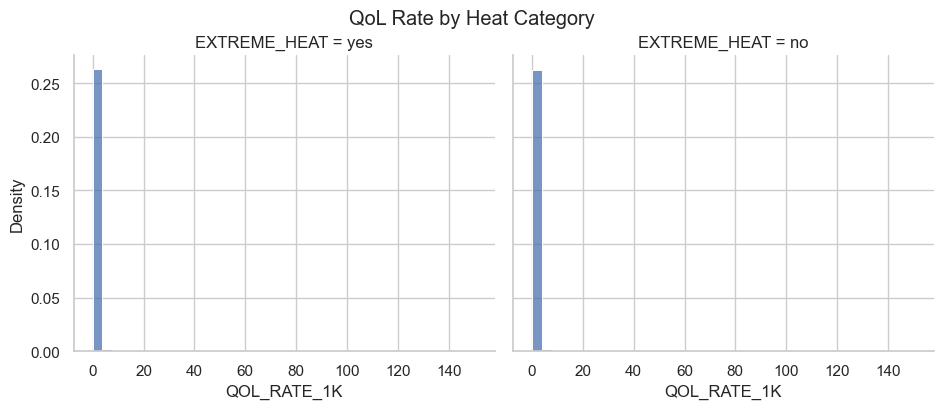

In [113]:
# Faceted histograms.
sns.displot(
    data = tracts_gdf,
    x = "QOL_RATE_1K",
    col = "EXTREME_HEAT",
    kind = "hist",
    bins = 40,
    kde = False,
    stat = "density",
    common_norm = False,
    height = 4,
    aspect = 1.2
)

plt.suptitle("QoL Rate by Heat Category", y = 1.02)
plt.show()

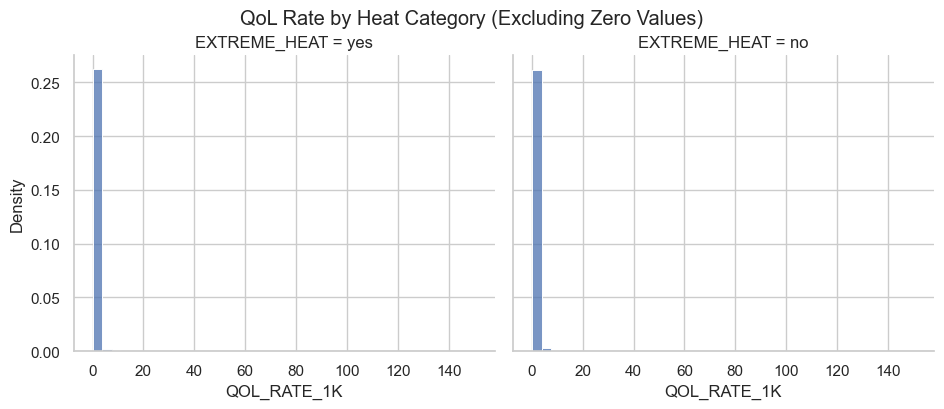

In [114]:
# Filter to exclude zero values in QOL_RATE_1K column.
tracts_gdf_non_zero = tracts_gdf[tracts_gdf["QOL_RATE_1K"] > 0].copy()

sns.displot(
    data = tracts_gdf_non_zero,
    x = "QOL_RATE_1K",
    col = "EXTREME_HEAT",
    kind = "hist",
    bins = 40,
    kde = False,
    stat = "density",
    common_norm = False,
    height = 4,
    aspect = 1.2
)

plt.suptitle("QoL Rate by Heat Category (Excluding Zero Values)", y = 1.02)
plt.show()

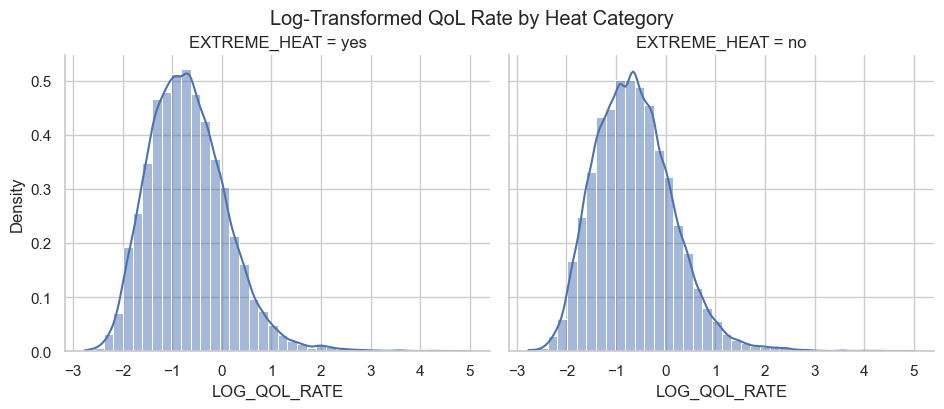

In [ ]:
# Create a new log-transformed column.
tracts_gdf_non_zero = tracts_gdf_non_zero.copy()
tracts_gdf_non_zero["LOG_QOL_RATE"] = np.log(tracts_gdf_non_zero["QOL_RATE_1K"])

# 2. Plot the log-transformed data
sns.displot(
    data = tracts_gdf_non_zero,
    x = "LOG_QOL_RATE",
    col = "EXTREME_HEAT",
    kind = "hist",
    bins = 40,
    kde = True,
    stat = "density",
    common_norm = False,
    height = 4,
    aspect = 1.2
)

plt.suptitle("Log-Transformed QoL Rate by Heat Category", y = 1.02)
plt.show()

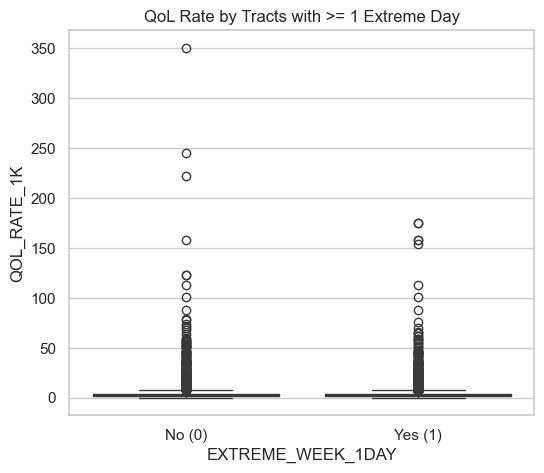

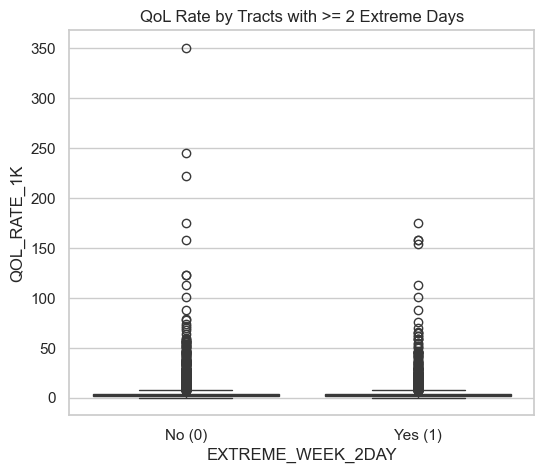

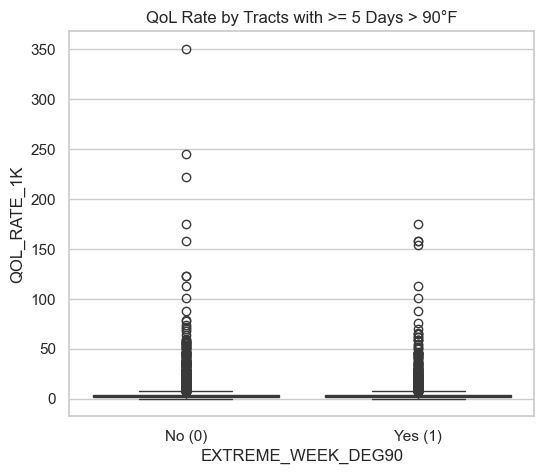

In [116]:
def boxplot_categories(df, category_col, value_col, title):
    """Generates a box plot comparing a continuous variable across a binary category."""
    plt.figure(figsize = (6, 5))
    sns.boxplot(
        data = df,
        x = category_col,
        y = value_col,
        hue = category_col,
        palette =  "viridis",
        order = [0, 1],
        legend = False
    )
    plt.xticks([0, 1], ['No (0)', 'Yes (1)'])
    plt.xlabel(category_col)
    plt.ylabel(value_col)
    plt.title(title)
    plt.show()

# At least 1 EXTREME_DAY
boxplot_categories(
    tracts_weekly,
    "EXTREME_WEEK_1DAY",
    "QOL_RATE_1K",
    "QoL Rate by Tracts with >= 1 Extreme Day"
)

# t least 2 EXTREME_DAY
boxplot_categories(
    tracts_weekly,
    "EXTREME_WEEK_2DAY",
    "QOL_RATE_1K",
    "QoL Rate by Tracts with >= 2 Extreme Days"
)

# At least 5 days > 90°F
boxplot_categories(
    tracts_weekly,
    "EXTREME_WEEK_DEG90",
    "QOL_RATE_1K",
    "QoL Rate by Tracts with >= 5 Days > 90°F"
)

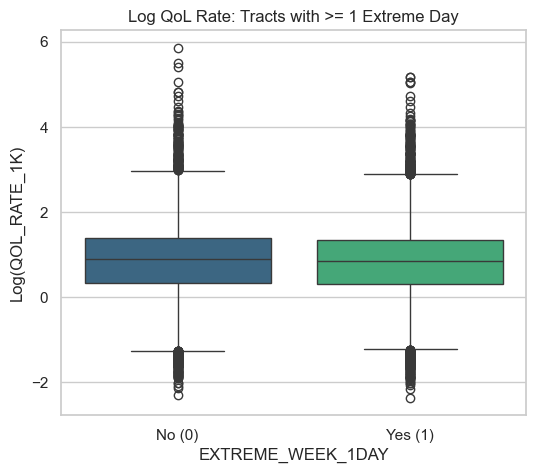

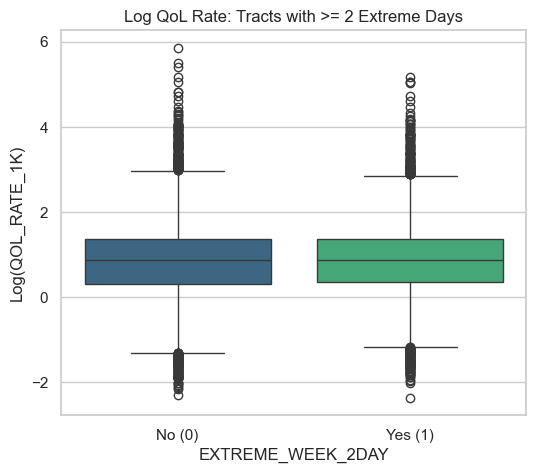

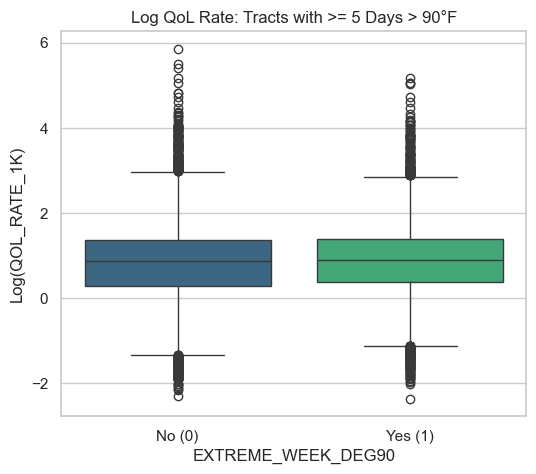

In [117]:
# Filter the data to non-zero QoL rates
tracts_weekly_non_zero = tracts_weekly[tracts_weekly["QOL_RATE_1K"] > 0].copy()

# Log-transform the non-zero data
tracts_weekly_non_zero["LOG_QOL_RATE"] = np.log(tracts_weekly_non_zero["QOL_RATE_1K"])

def boxplot_log_categories(df, category_col, value_col, title):
    """Generates a box plot for log-transformed data across a binary category."""
    plt.figure(figsize=(6, 5))
    sns.boxplot(
        data=df,
        x=category_col,
        y=value_col,
        hue=category_col,
        palette="viridis",
        order=[0, 1],
        legend=False
    )
    plt.xticks([0, 1], ['No (0)', 'Yes (1)'])
    plt.xlabel(category_col)
    plt.ylabel("Log(QOL_RATE_1K)")
    plt.title(title)
    plt.show()

# At least 1 EXTREME_DAY
boxplot_log_categories(
    tracts_weekly_non_zero,
    "EXTREME_WEEK_1DAY",
    "LOG_QOL_RATE",
    "Log QoL Rate: Tracts with >= 1 Extreme Day"
)

# At least 2 EXTREME_DAY
boxplot_log_categories(
    tracts_weekly_non_zero,
    "EXTREME_WEEK_2DAY",
    "LOG_QOL_RATE",
    "Log QoL Rate: Tracts with >= 2 Extreme Days"
)

# At least 5 days > 90°F
boxplot_log_categories(
    tracts_weekly_non_zero,
    "EXTREME_WEEK_DEG90",
    "LOG_QOL_RATE",
    "Log QoL Rate: Tracts with >= 5 Days > 90°F"
)

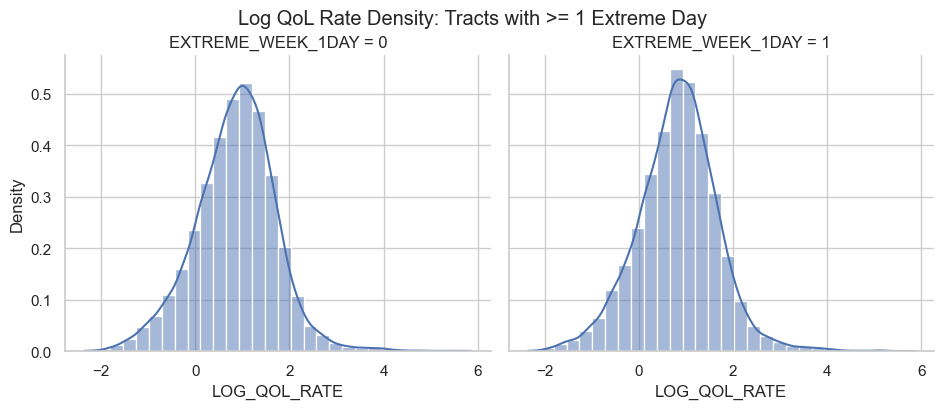

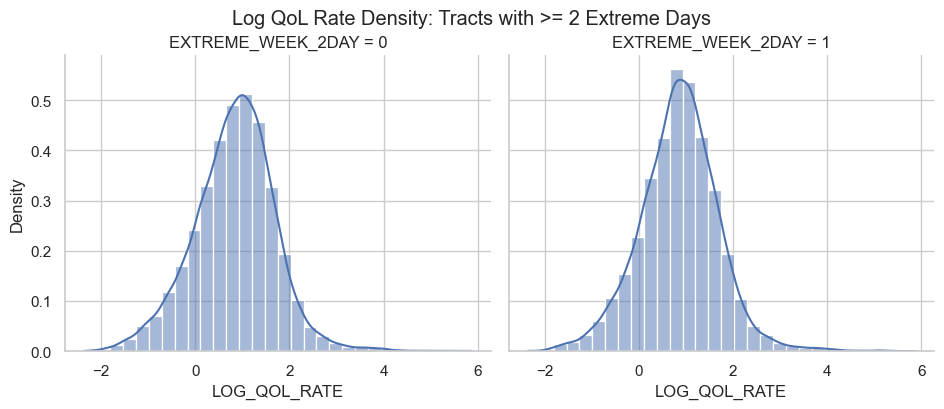

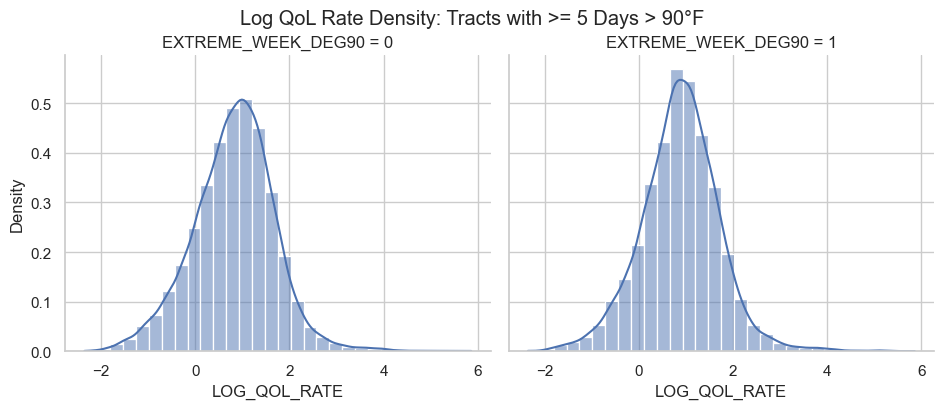

In [118]:
def hist_log_categories(df, category_col, value_col, title):
    """Generates faceted histograms comparing log-transformed QoL across a binary category."""
    
    sns.displot(
        data=df,
        x=value_col,
        col=category_col,
        kind="hist",
        bins=30,
        kde=True,
        stat="density",
        common_norm=False,
        height=4,
        aspect=1.2
    )
    plt.suptitle(title, y=1.02)
    plt.show()

# At least 1 EXTREME_DAY
hist_log_categories(
    tracts_weekly_non_zero,
    "EXTREME_WEEK_1DAY",
    "LOG_QOL_RATE",
    "Log QoL Rate Density: Tracts with >= 1 Extreme Day"
)

# At least 2 EXTREME_DAY
hist_log_categories(
    tracts_weekly_non_zero,
    "EXTREME_WEEK_2DAY",
    "LOG_QOL_RATE",
    "Log QoL Rate Density: Tracts with >= 2 Extreme Days"
)

# At least 5 days > 90°F
hist_log_categories(
    tracts_weekly_non_zero,
    "EXTREME_WEEK_DEG90",
    "LOG_QOL_RATE",
    "Log QoL Rate Density: Tracts with >= 5 Days > 90°F"
)

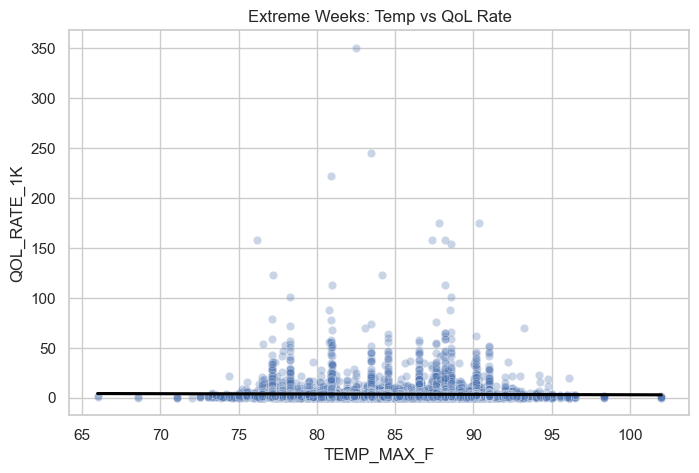

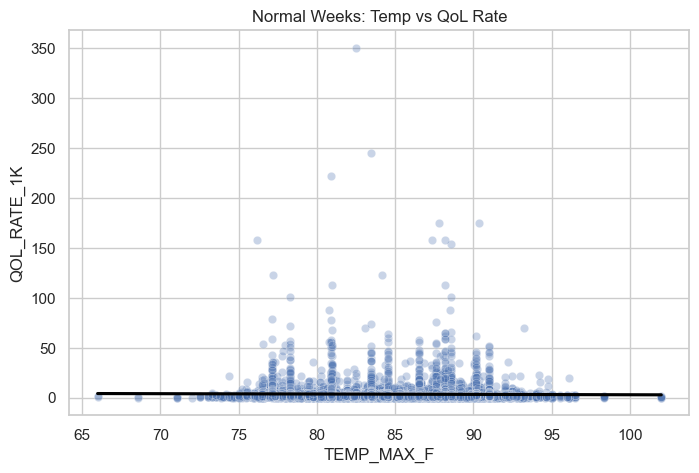

In [119]:
# Scatter plots.
def scatter(df, x, y, title):
    plt.figure()
    sns.scatterplot(data = df, x = x, y = y, alpha = 0.3)
    sns.regplot(data = df, x = x, y = y, scatter = False, color = "black")
    plt.title(title)
    plt.show()

scatter(tracts_weekly, "TEMP_MAX_F", "QOL_RATE_1K", "Extreme Weeks: Temp vs QoL Rate")
scatter(tracts_weekly, "TEMP_MAX_F", "QOL_RATE_1K", "Normal Weeks: Temp vs QoL Rate")

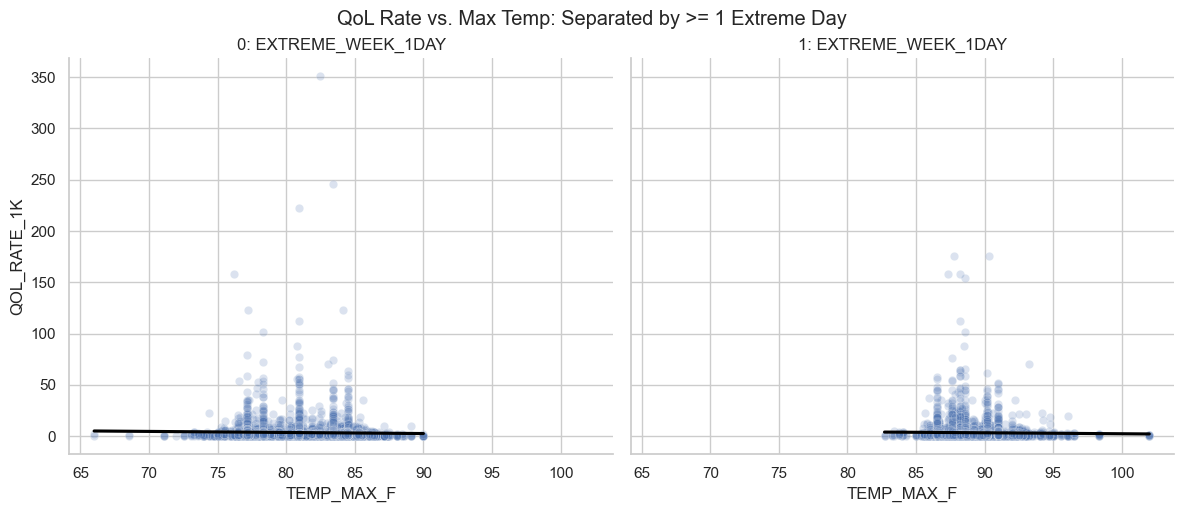

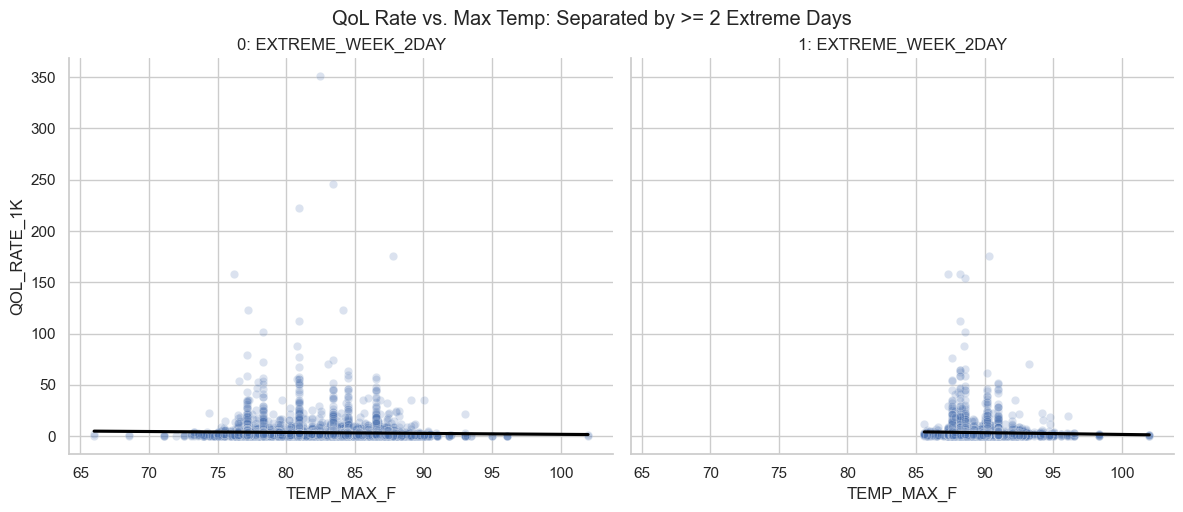

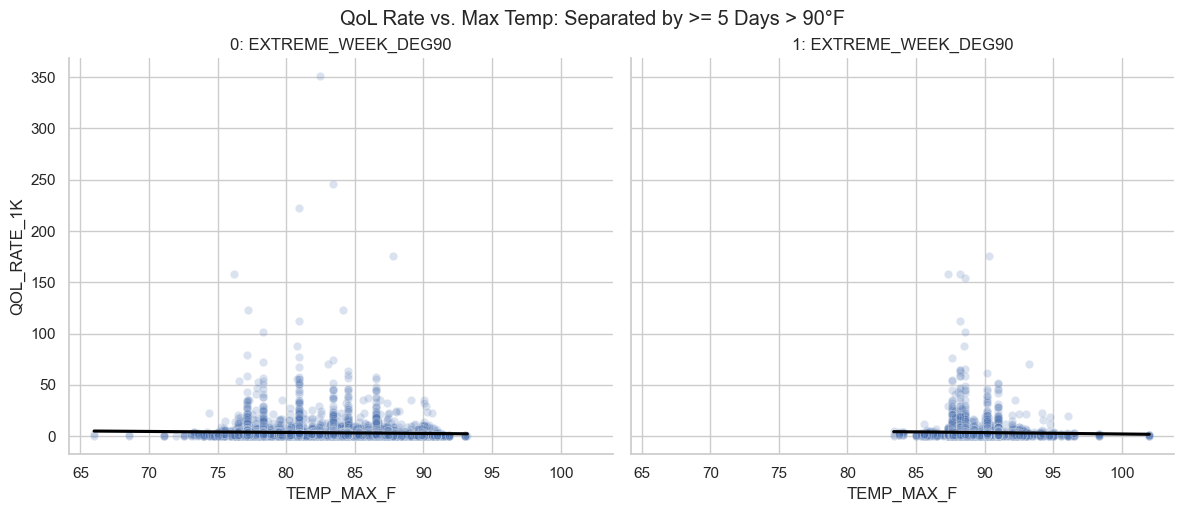

In [120]:
def scatter_faceted_categories(df, x_col, y_col, category_col, title):
    """
    Generates faceted scatter plots comparing two continuous variables, 
    separated into columns by a binary category.
    """
    
    # Use relplot for scatter plots and faceting
    g = sns.relplot(
        data=df,
        x=x_col,
        y=y_col,
        col=category_col,
        kind="scatter",
        alpha=0.2,
        height=5,
        aspect=1.2
    )
    
    g.map(sns.regplot, x_col, y_col, scatter=False, color="black")
    
    g.fig.suptitle(title, y=1.02)
    
    # Rename the column titles for clarity
    g.set_titles(col_template="{col_name}: {col_var}")
    
    plt.show()

# 1. EXTREME_WEEK_1DAY
scatter_faceted_categories(
    tracts_weekly,
    "TEMP_MAX_F",
    "QOL_RATE_1K",
    "EXTREME_WEEK_1DAY",
    "QoL Rate vs. Max Temp: Separated by >= 1 Extreme Day"
)

# 2. EXTREME_WEEK_2DAY
scatter_faceted_categories(
    tracts_weekly,
    "TEMP_MAX_F",
    "QOL_RATE_1K",
    "EXTREME_WEEK_2DAY",
    "QoL Rate vs. Max Temp: Separated by >= 2 Extreme Days"
)

# 3. EXTREME_WEEK_DEG90
scatter_faceted_categories(
    tracts_weekly,
    "TEMP_MAX_F",
    "QOL_RATE_1K",
    "EXTREME_WEEK_DEG90",
    "QoL Rate vs. Max Temp: Separated by >= 5 Days > 90°F"
)

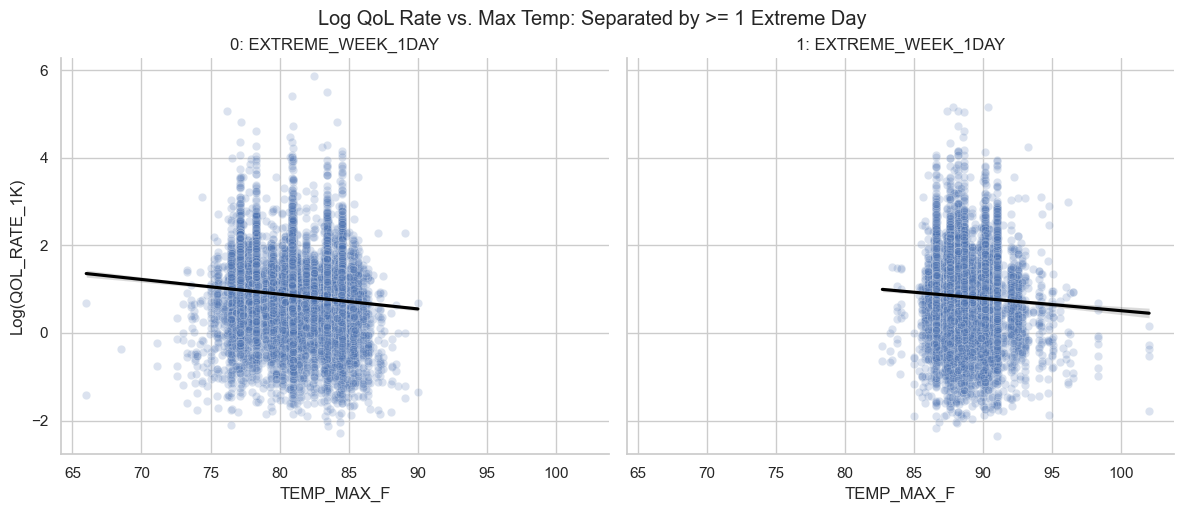

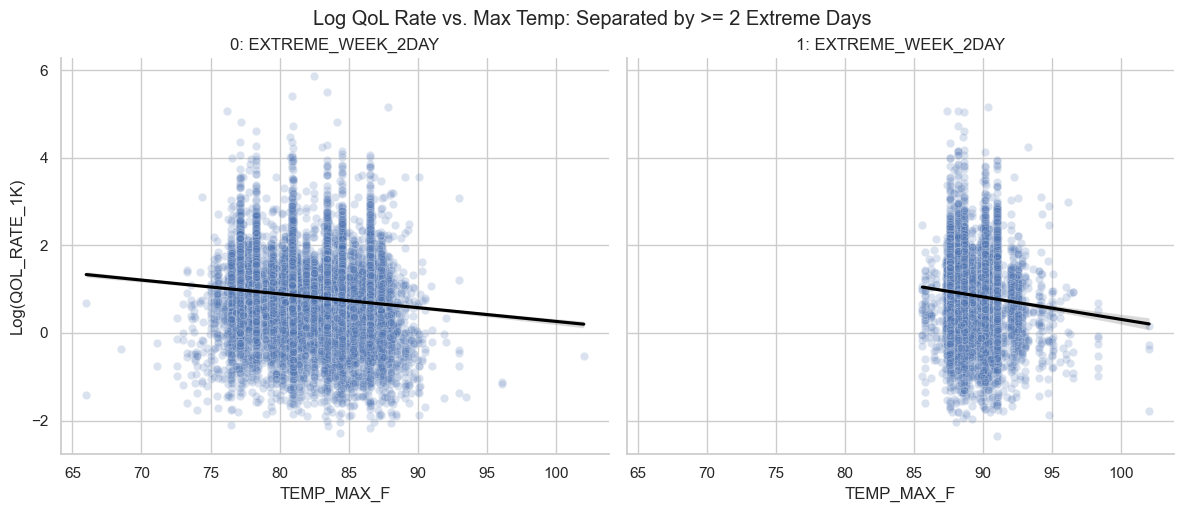

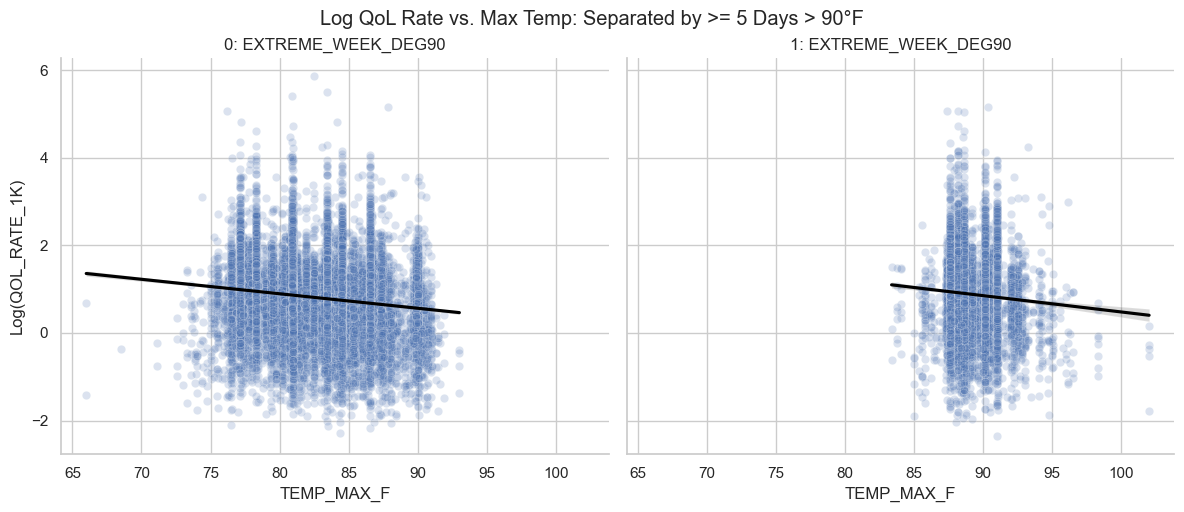

In [126]:
# Filter out zero values in QOL_RATE_1K and apply log transformation
tracts_weekly_non_zero = tracts_weekly[tracts_weekly["QOL_RATE_1K"] > 0].copy()
tracts_weekly_non_zero["LOG_QOL_RATE"] = np.log(tracts_weekly_non_zero["QOL_RATE_1K"])

def scatter_faceted_categories(df, x_col, y_col, category_col, title):
    """
    Generates faceted scatter plots comparing two variables, 
    separated into columns by a binary category.
    """
    
    g = sns.relplot(
        data=df,
        x=x_col,
        y=y_col,
        col=category_col,
        kind="scatter",
        alpha=0.2,
        height=5,
        aspect=1.2
    )
    
    g.map(sns.regplot, x_col, y_col, scatter=False, color="black")
    
    g.fig.suptitle(title, y=1.02)
    g.set_titles(col_template="{col_name}: {col_var}")
    g.set_axis_labels(x_col, "Log(QOL_RATE_1K)")
    
    plt.show()

# 1. EXTREME_WEEK_1DAY
scatter_faceted_categories(
    tracts_weekly_non_zero,
    "TEMP_MAX_F",
    "LOG_QOL_RATE",
    "EXTREME_WEEK_1DAY",
    "Log QoL Rate vs. Max Temp: Separated by >= 1 Extreme Day"
)

# 2. EXTREME_WEEK_2DAY
scatter_faceted_categories(
    tracts_weekly_non_zero,
    "TEMP_MAX_F",
    "LOG_QOL_RATE",
    "EXTREME_WEEK_2DAY",
    "Log QoL Rate vs. Max Temp: Separated by >= 2 Extreme Days"
)

# 3. EXTREME_WEEK_DEG90
scatter_faceted_categories(
    tracts_weekly_non_zero,
    "TEMP_MAX_F",
    "LOG_QOL_RATE",
    "EXTREME_WEEK_DEG90",
    "Log QoL Rate vs. Max Temp: Separated by >= 5 Days > 90°F"
)

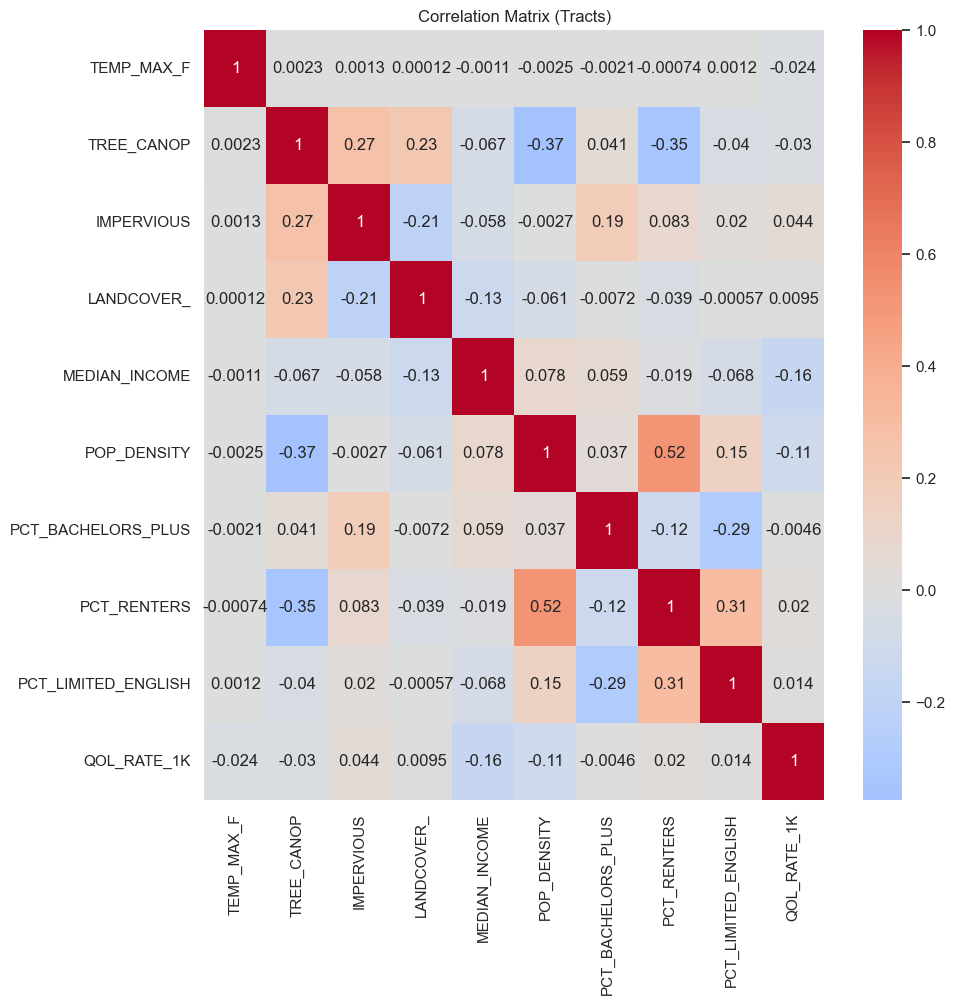

In [127]:
# Correlation matrix.
predictors = [
    "TEMP_MAX_F","TREE_CANOP","IMPERVIOUS","LANDCOVER_",
    "MEDIAN_INCOME","POP_DENSITY","PCT_BACHELORS_PLUS",
    "PCT_RENTERS","PCT_LIMITED_ENGLISH"
]

corr = tracts_gdf[predictors + ["QOL_RATE_1K"]].corr()

plt.figure(figsize = (10, 10))
sns.heatmap(corr, annot = True, cmap = "coolwarm", center = 0)
plt.title("Correlation Matrix (Tracts)")
plt.show()

In [128]:
# VIF calculations.
def compute_vif(df, cols):
    X = df[cols].dropna().assign(const = 1)
    return pd.DataFrame({
        "Variable": cols,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(len(cols))]
    })

vif_table = compute_vif(tracts_gdf, predictors)
print("VIF Table:")
print(vif_table)

VIF Table:
              Variable       VIF
0           TEMP_MAX_F  1.000014
1           TREE_CANOP  1.458120
2           IMPERVIOUS  1.287685
3           LANDCOVER_  1.125523
4        MEDIAN_INCOME  1.039586
5          POP_DENSITY  1.499029
6   PCT_BACHELORS_PLUS  1.173387
7          PCT_RENTERS  1.638259
8  PCT_LIMITED_ENGLISH  1.204449


In [129]:
# # COMPUTATIONALLY INTENSIVE.
# # 311 point density.
# # Reproject both.
# points = points.to_crs("EPSG:2263")
# env = env.to_crs("EPSG:2263")

# points["centroid"] = points.geometry.centroid

# fig, ax = plt.subplots(1, 1, figsize = (8, 8))
# env.boundary.plot(ax = ax, color = "black", linewidth = 0.5)

# sns.kdeplot(
#     x = points["centroid"].x,
#     y = points["centroid"].y,
#     cmap = "magma",
#     fill = True,
#     bw_adjust = 0.3
# )

# plt.title("311 Point Density Heatmap (2025)")
# plt.axis("off")
# plt.show()

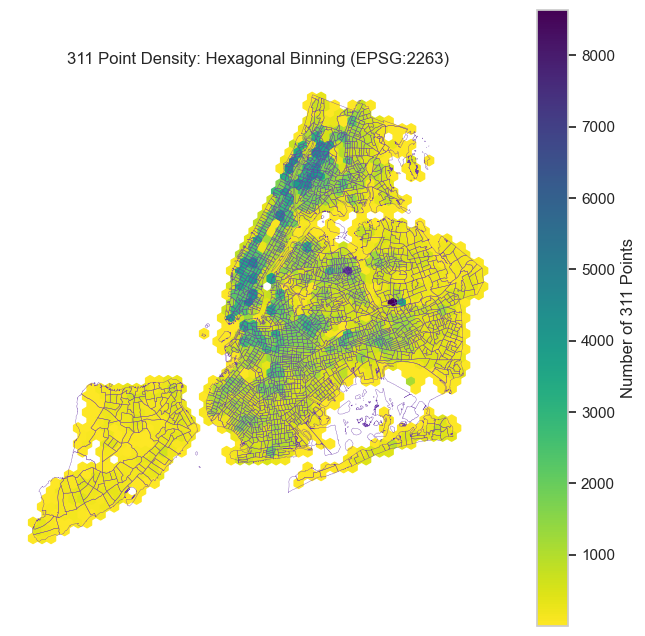

In [130]:
# 311 hexagonal density.
# Reproject both.
points = points.to_crs("EPSG:2263")
env = env.to_crs("EPSG:2263")

points["centroid"] = points.geometry.centroid

fig, ax = plt.subplots(1, 1, figsize = (8, 8))

# Plot boundary.
env.boundary.plot(ax = ax, color = "#6c3baa", linewidth = 0.25)

hb = ax.hexbin(
    x = points["centroid"].x,
    y = points["centroid"].y,
    gridsize = 50,
    cmap = "viridis_r",
    mincnt = 1
)
# Add a color bar to show the point count scale
plt.colorbar(hb, ax = ax, label = "Number of 311 Points")

plt.title("311 Point Density: Hexagonal Binning (EPSG:2263)")
plt.axis("off")
plt.show()

In [131]:
# Reproject back to standard.
points = points.to_crs("EPSG:4326")
env = env.to_crs("EPSG:4326")

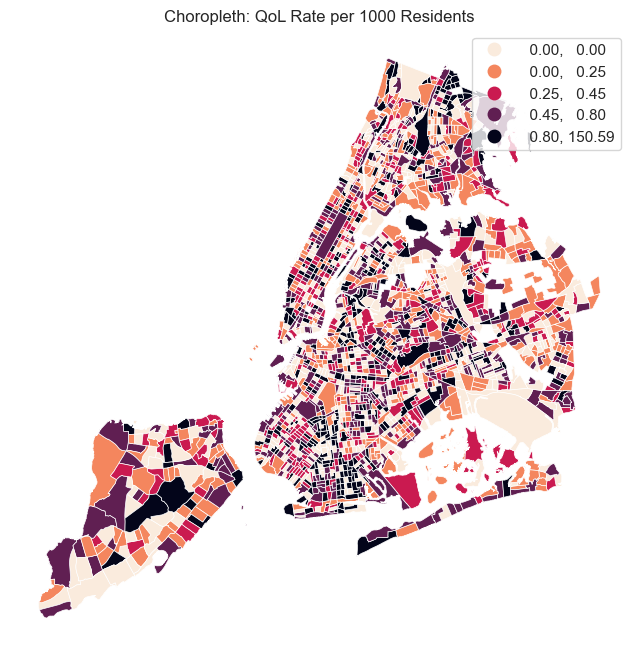

In [132]:
# Choropleth.
tracts_plot = tracts_gdf

fig, ax = plt.subplots(1, 1, figsize = (8, 8))

tracts_plot.plot(
    column = "QOL_RATE_1K",
    cmap = "rocket_r",
    legend = True,
    scheme = "quantiles",
    k = 5,
    ax = ax,
    linewidth = 0.5
)

plt.title("Choropleth: QoL Rate per 1000 Residents")
ax.axis("off")
plt.show()

c:\Users\Tess\.conda\envs\geospatial\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


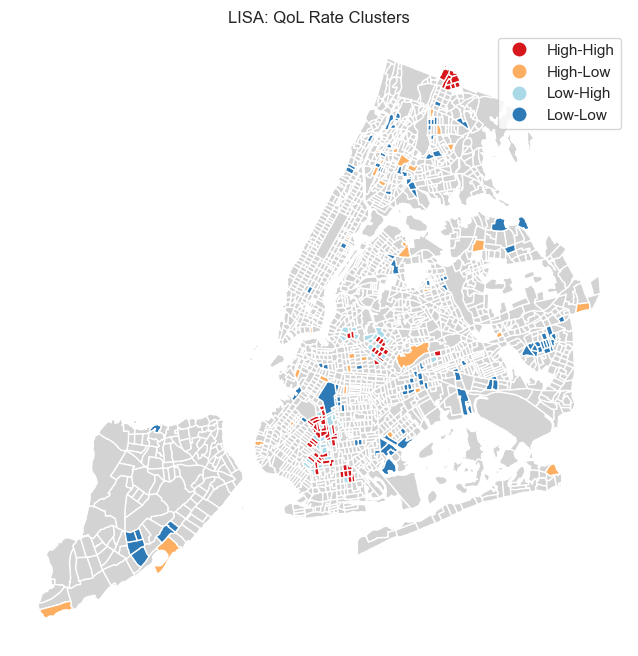

In [133]:
# LISA cluster map.
lisa_df = tracts_plot.dropna(subset = ["geometry", "QOL_RATE_1K"]).copy()
w = KNN.from_dataframe(lisa_df, k = 6)
w.transform = "r"

y = lisa_df["QOL_RATE_1K"].values
m_local = Moran_Local(y, w)

lisa_df["Isig"] = m_local.p_sim < 0.05
lisa_df["quad"] = m_local.q

quad_labels = {
    1: "High-High",
    2: "Low-High",
    3: "Low-Low",
    4: "High-Low"
}
lisa_df["quad_label"] = lisa_df["quad"].map(quad_labels)

cluster_labels = ["High-High", "Low-High", "Low-Low", "High-Low"]

cluster_colors = [
    "#d6181c", # 1: High-High (Red)
    "#fdae61", # 2: Low-High (Light Blue)
    "#aad9e8", # 3: Low-Low (Dark Blue)
    "#2d7ab6"  # 4: High-Low (Orange)
]

# Create the custom color and normalizer.
cmap = mcolors.ListedColormap(cluster_colors)

# Normalizer maps categorical labels to color indices.
norm = mcolors.BoundaryNorm(
    # Define boundaries between colors.
    boundaries = range(len(cluster_labels) + 1),
    ncolors = len(cluster_labels)
)

fig, ax = plt.subplots(1, 1, figsize = (8, 8))

lisa_df.plot(color = "lightgrey", ax = ax)

lisa_df[lisa_df["Isig"]].plot(
    column = "quad_label",
    categorical = True,
    cmap = cmap,
    legend = True,
    ax = ax
)

plt.title("LISA: QoL Rate Clusters")
plt.axis("off")
plt.show()

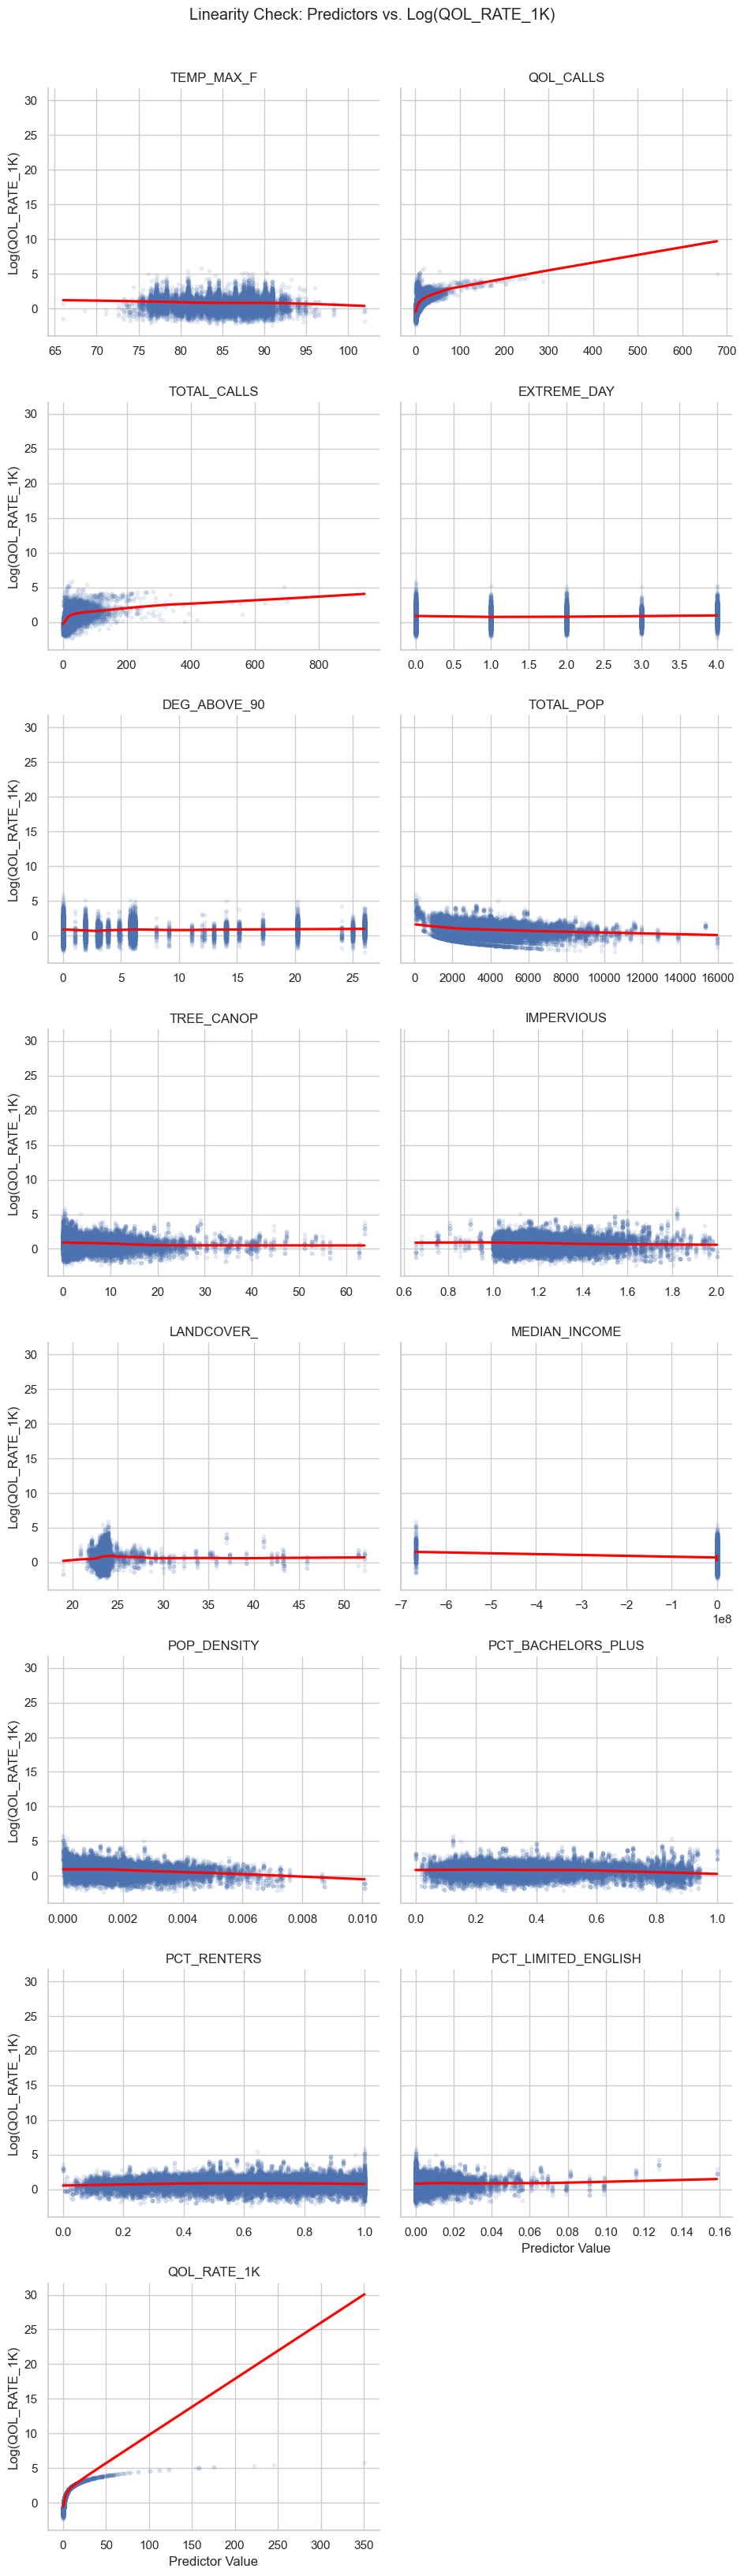

In [141]:
# Filter out zero values and apply log transformation
tracts_weekly_non_zero = tracts_weekly[tracts_weekly["QOL_RATE_1K"] > 0].copy()
tracts_weekly_non_zero["LOG_QOL_RATE"] = np.log(tracts_weekly_non_zero["QOL_RATE_1K"])

# ADD ALL your continuous predictors here for a comprehensive check
predictor_cols = ["TEMP_MAX_F", 'QOL_CALLS', 'TOTAL_CALLS', 'TEMP_MAX_F',
       'EXTREME_DAY', 'DEG_ABOVE_90', 'TOTAL_POP', 'TREE_CANOP', 'IMPERVIOUS',
       'LANDCOVER_', 'MEDIAN_INCOME', 'POP_DENSITY', 'PCT_BACHELORS_PLUS',
       'PCT_RENTERS', 'PCT_LIMITED_ENGLISH', 'QOL_RATE_1K', 'LOG_QOL_RATE']

def plot_predictor_linearity(df, predictors, y_col):
    """
    Generates faceted scatter plots with regression lines to assess linearity 
    between multiple predictors and a dependent variable.
    """
    
    # Restructure the data from wide to long format
    # This stacks all predictor columns into one column called 'Value' 
    # and creates a new 'Predictor' column to identify the original variable.
    df_long = pd.melt(
        df, 
        id_vars=[y_col], 
        value_vars=predictors, 
        var_name='Predictor', 
        value_name='Value'
    )

    # Use FacetGrid to create a plot for each predictor
    g = sns.FacetGrid(
        df_long, 
        col='Predictor', 
        col_wrap=2, # Adjust the number to set how many plots are side-by-side
        sharex=False, # Important: Allows the x-axis scale to change for different predictors
        height=4, 
        aspect=1.2
    )

    # Map the scatter plot and the regression line (regplot) to each facet
    # alpha is set low because you likely have many points
    g.map(sns.regplot, 'Value', y_col, 
          scatter_kws={'alpha': 0.1, 's': 10}, 
          line_kws={'color': 'red'},
          lowess=True)

    # Set titles and labels
    g.set_axis_labels("Predictor Value", "Log(QOL_RATE_1K)")
    g.set_titles(col_template="{col_name}")
    g.fig.suptitle("Linearity Check: Predictors vs. Log(QOL_RATE_1K)", y=1.02)
    
    plt.show()

plot_predictor_linearity(
    tracts_weekly_non_zero,
    predictor_cols,
    "LOG_QOL_RATE"
)

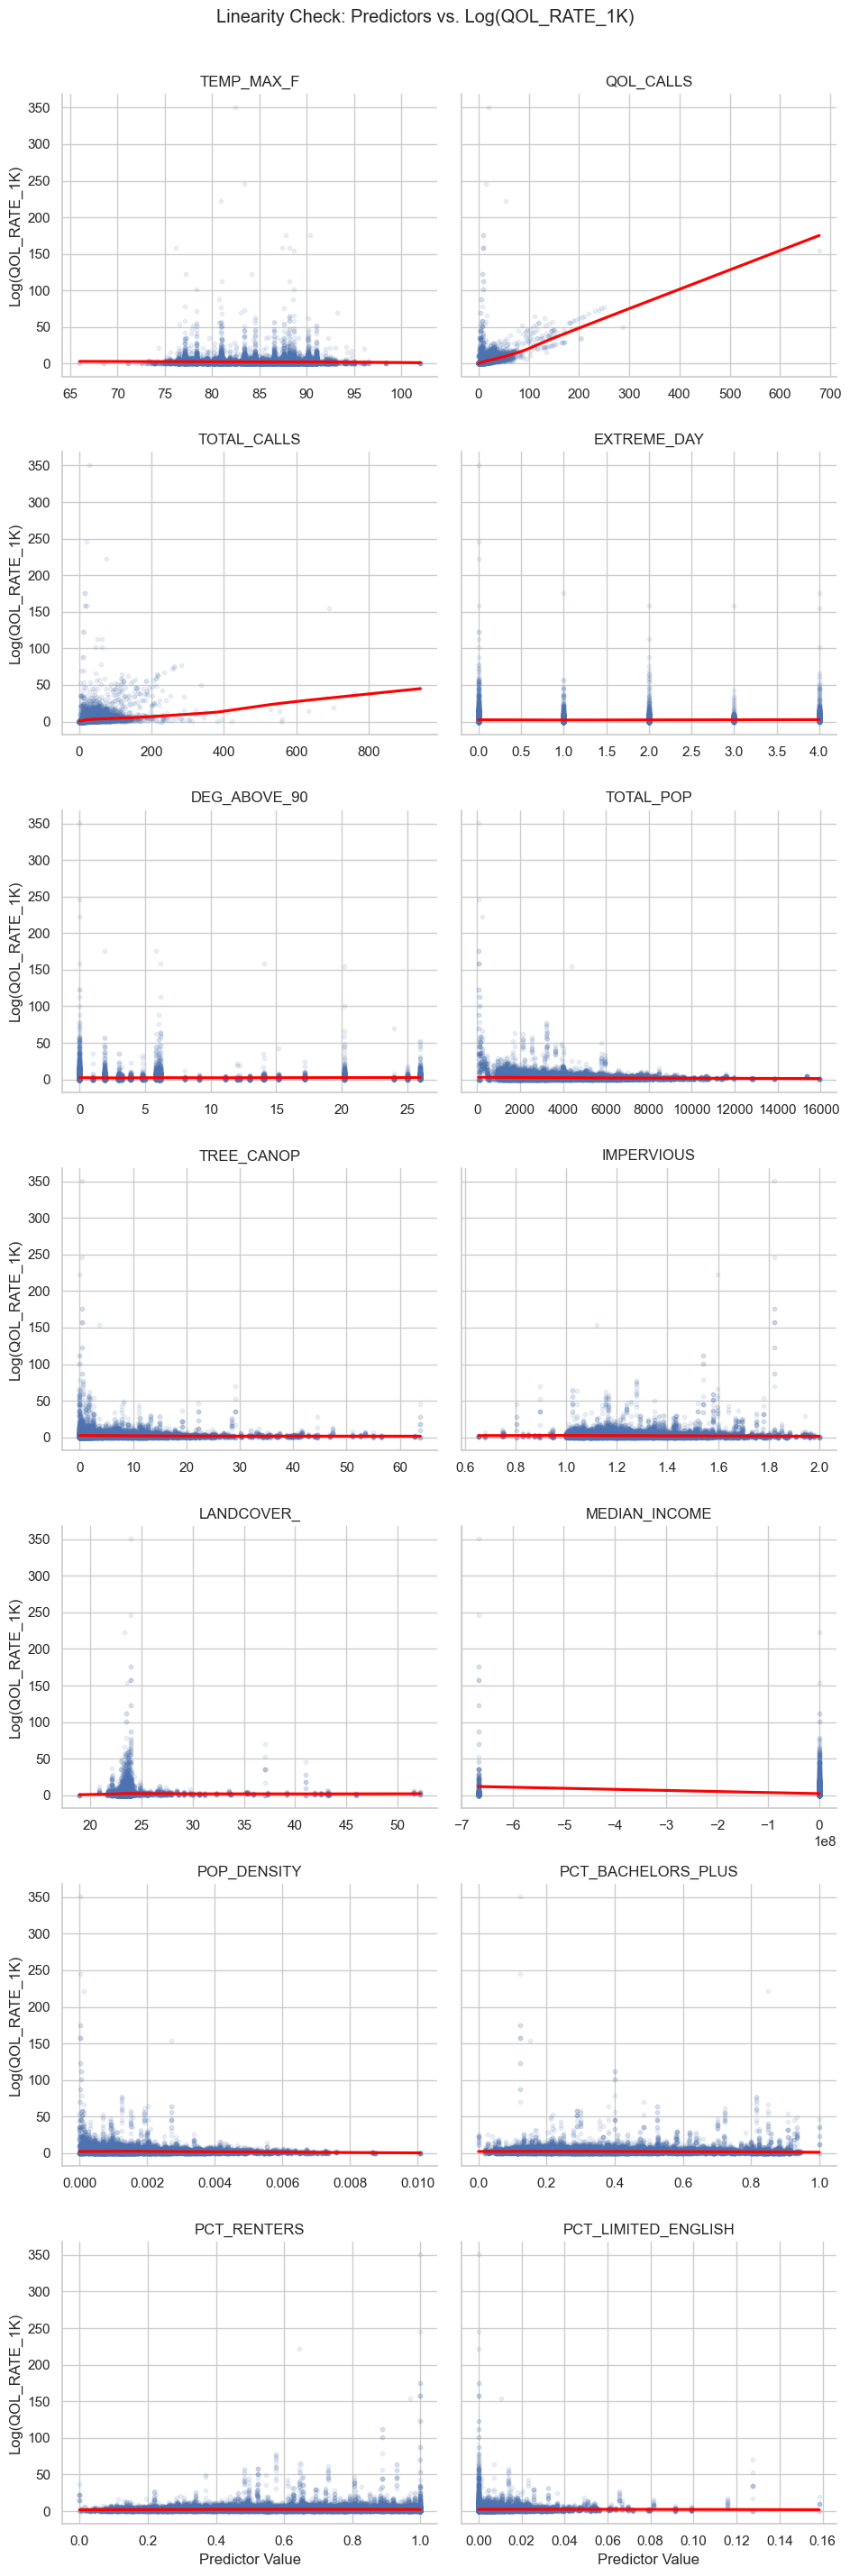

In [142]:
# ADD ALL your continuous predictors here for a comprehensive check
predictor_cols = ["TEMP_MAX_F", 'QOL_CALLS', 'TOTAL_CALLS', 'TEMP_MAX_F',
       'EXTREME_DAY', 'DEG_ABOVE_90', 'TOTAL_POP', 'TREE_CANOP', 'IMPERVIOUS',
       'LANDCOVER_', 'MEDIAN_INCOME', 'POP_DENSITY', 'PCT_BACHELORS_PLUS',
       'PCT_RENTERS', 'PCT_LIMITED_ENGLISH', 'QOL_RATE_1K']

plot_predictor_linearity(
    tracts_weekly,
    predictor_cols,
    "QOL_RATE_1K"
)